In [994]:
import time
from datetime import datetime
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## Описание задачи:
плашка

Для прогнозирования временных рядов цен на медь можно выбрать различные метрики оценки точности модели. RMSE (Root Mean Squared Error) и MAE (Mean Absolute Error) являются двумя из самых популярных метрик для этой задачи.

RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны.

Выбор между RMSE и MAE зависит от конкретной задачи и предпочтений аналитика. Если вам важны большие ошибки и вы хотите избежать их, то RMSE может быть более подходящей метрикой. Если вам важна общая ошибка без учета направления, то MAE может быть предпочтительнее.

В конечном счете, рекомендуется провести сравнительный анализ результатов, используя обе метрики, чтобы определить, какая из них лучше соответствует вашим потребностям и целям прогнозирования.

плашка

плашка

плашка

---

## Технический блок.

## Содержание:
### - Парсер
### - Функция проверки стационарности ряда

### В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

In [995]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-18,8320.0,8388.0,147.575
2023-09-15,8376.5,8427.0,143.375
2023-09-14,8423.0,8465.0,143.375
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-18,8320.0,8388.0,147.575
2023-09-15,8376.5,8427.0,143.375
2023-09-14,8423.0,8465.0,143.375
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65


#### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [996]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [997]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'
    
    return result_row

In [998]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock.csv', 'a') as file:
                file.write(metric)

        
def log_metrics_spot(metric):
    with open('./data/errors/spot.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot.csv', 'a') as file:
                file.write(metric)


In [999]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

---

## Часть 0.

### Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [1000]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2709.000000,2709.000000,2709.000000
mean,6865.938169,6869.736065,233.364876
std,1485.867942,1479.709216,127.372059
min,0.000000,0.000000,0.000000
25%,5812.000000,5829.500000,143.425000
50%,6699.500000,6689.000000,216.950000
75%,7778.500000,7783.500000,299.325000
max,10730.000000,10720.000000,678.225000


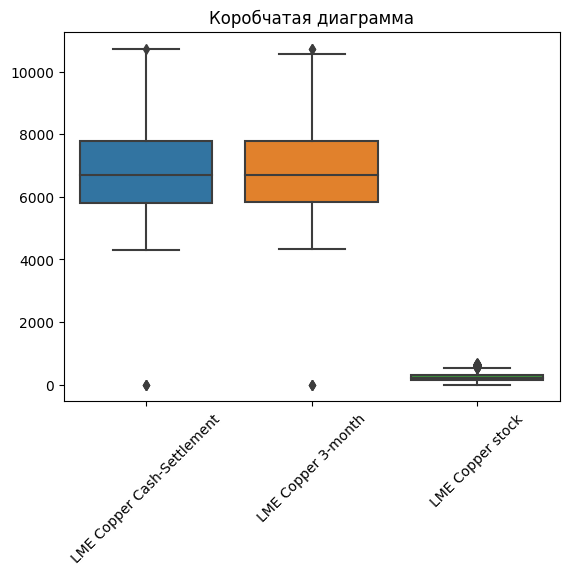

In [1001]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2705.000000,2705.000000,2705.000000
mean,6873.996858,6877.792052,233.452329
std,1469.071017,1462.818208,127.364335
min,4310.500000,4320.500000,51.175000
25%,5817.000000,5835.000000,143.425000
50%,6703.000000,6690.000000,217.175000
75%,7782.000000,7784.500000,299.325000
max,10730.000000,10720.000000,678.225000


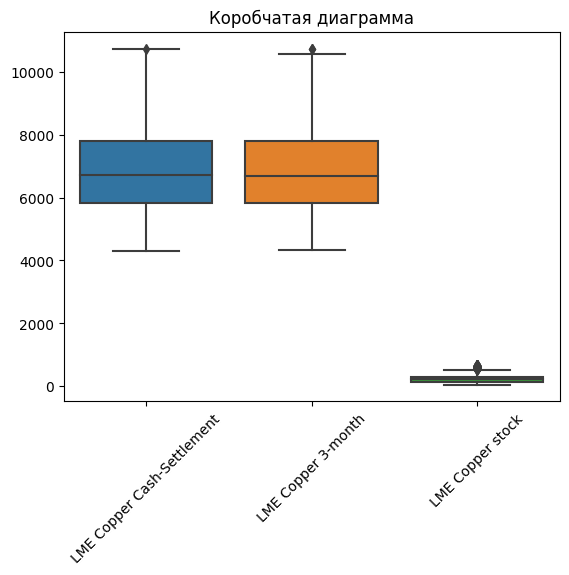

In [1002]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

In [1003]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [1004]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Copper 3-month'] = data['LME Copper 3-month'].shift(90)

# Обрежем 13 год, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2013]

display(data.head(), data.tail())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
364,2014-01-01,7417.000000,7245.5,365.700000
365,2014-01-02,7439.500000,7182.0,365.700000
366,2014-01-03,7335.500000,7189.5,359.075000
367,2014-01-04,7328.166667,7197.0,358.091667
368,2014-01-05,7320.833333,7204.5,357.108333


,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
85,2023-12-12,NaN,8465.0,NaN
86,2023-12-13,NaN,8427.0,NaN
87,2023-12-14,NaN,8414.0,NaN
88,2023-12-15,NaN,8401.0,NaN
89,2023-12-16,NaN,8388.0,NaN


Диапазон планирования равен 90 дней


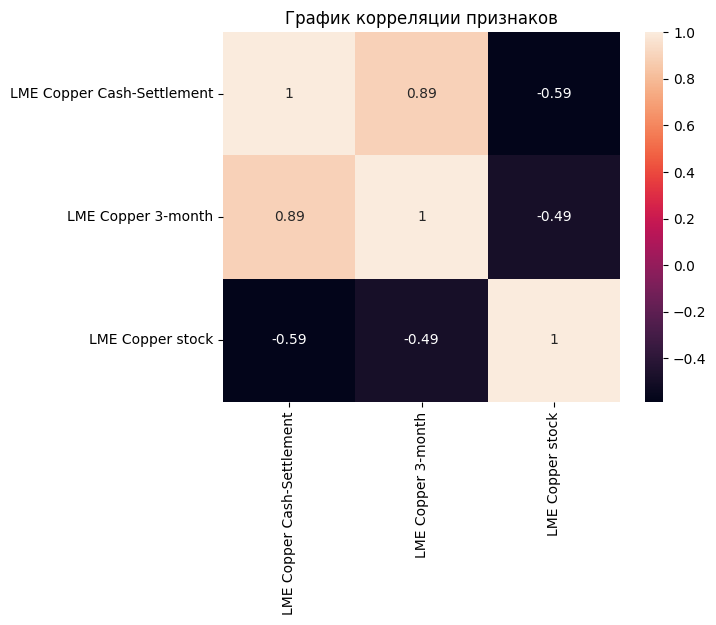

In [1005]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data['LME Copper stock'].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data['LME Copper stock'].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

#### Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.
#### Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.
#### Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

## Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [1006]:
# Будем прогнозировать временной ряд LME Copper stock и 
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data['LME Copper stock']
spot = working_data['LME Copper Cash-Settlement']

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

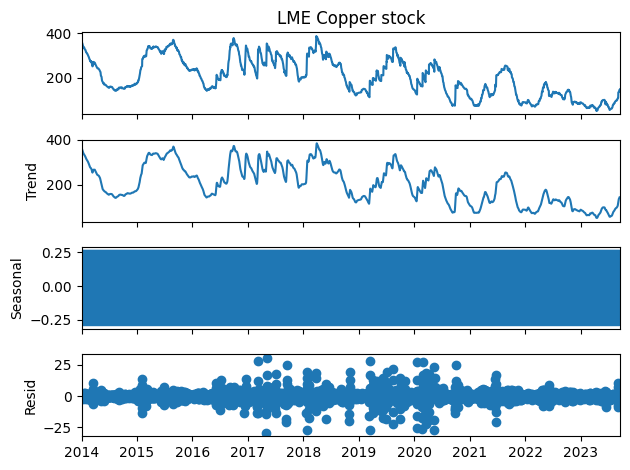

In [1007]:
decompose_stock.plot()
plt.show()

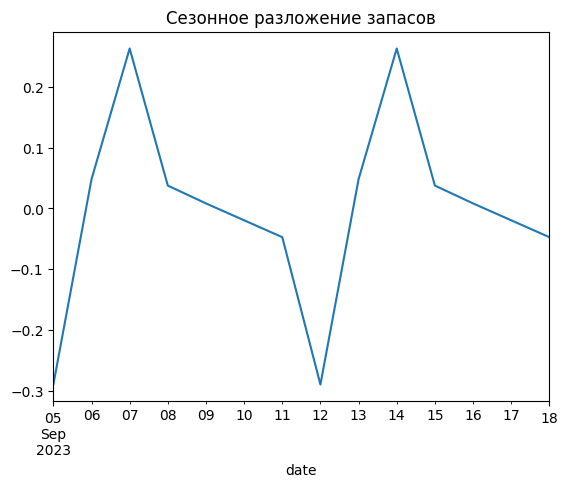

In [1008]:
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

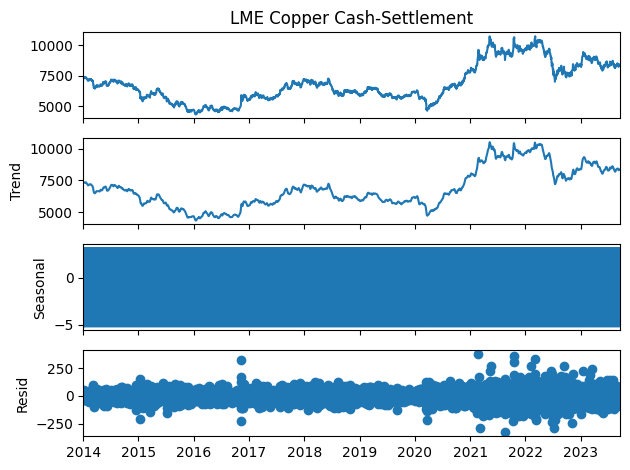

In [1009]:
decompose_spot.plot()
plt.show()

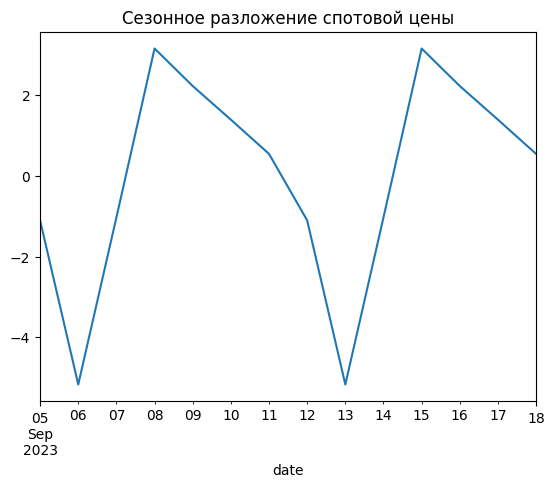

In [1010]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -18.182872288833945, 'crit_value (5%)': -2.862356807695006}
Единичных корней нет, ряд стационарен
{'p_value': -40.23232418858767, 'crit_value (5%)': -2.8623556551606115}


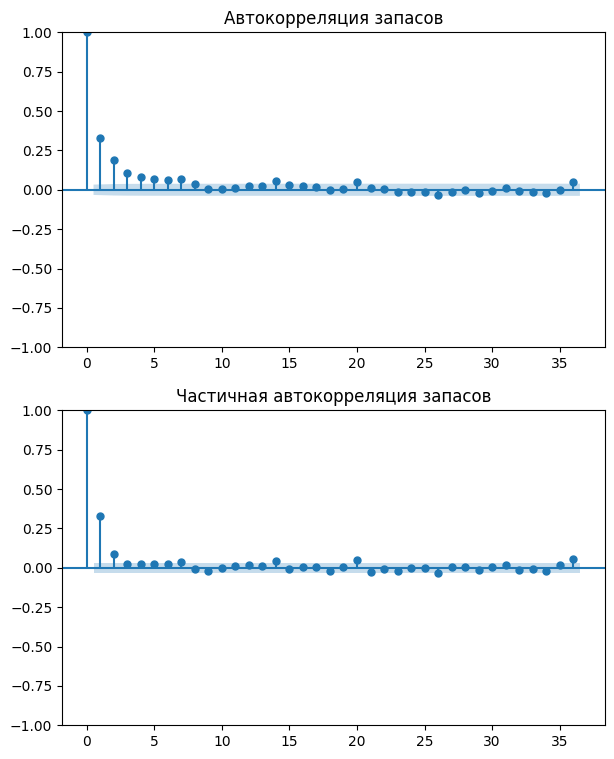

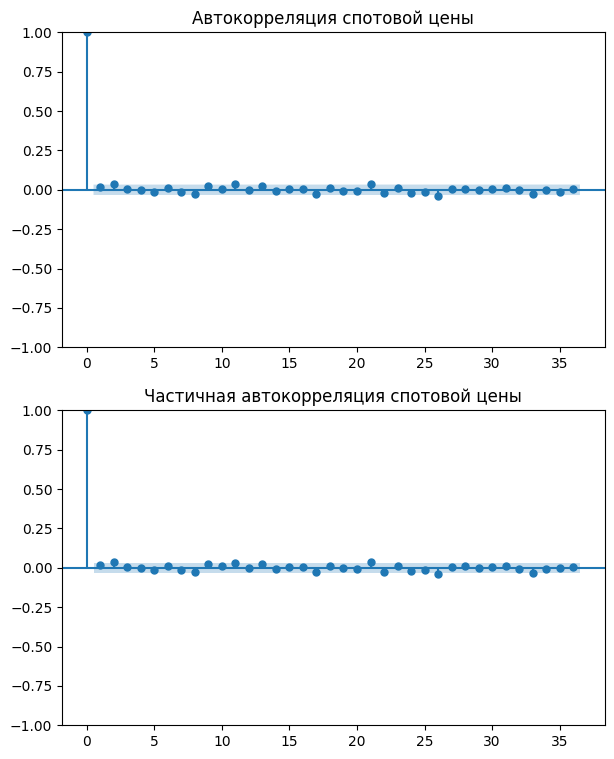

In [1011]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 1 (так же исходя из pacf)

In [1012]:
p_stock = 1
d_stock = 1
q_stock = 0

p_spot = 1
d_spot = 1
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [1013]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [1014]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [1015]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [1016]:
pred_ar_spot

2023-06-21    8563.859990
2023-06-22    8563.389112
2023-06-23    8566.150135
2023-06-24    8563.851111
2023-06-25    8561.676030
                 ...     
2023-09-14    8465.405199
2023-09-15    8468.902233
2023-09-16    8466.846905
2023-09-17    8464.792822
2023-09-18    8462.739985
Freq: D, Length: 90, dtype: float64

In [1017]:
test_spot

date
2023-06-21    8490.000000
2023-06-22    8670.500000
2023-06-23    8490.000000
2023-06-24    8472.333333
2023-06-25    8454.666667
                 ...     
2023-09-14    8423.000000
2023-09-15    8376.500000
2023-09-16    8357.666667
2023-09-17    8338.833333
2023-09-18    8320.000000
Name: LME Copper Cash-Settlement, Length: 90, dtype: float64

In [1018]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 23.831
MAE для AR-baseline-stock: 19.381
MAPE для AR-baseline-stock: 24.7%


RMSE для AR-baseline-spot: 177.588
MAE для AR-baseline-spot: 149.292
MAPE для AR-baseline-spot: 1.7999999999999998%




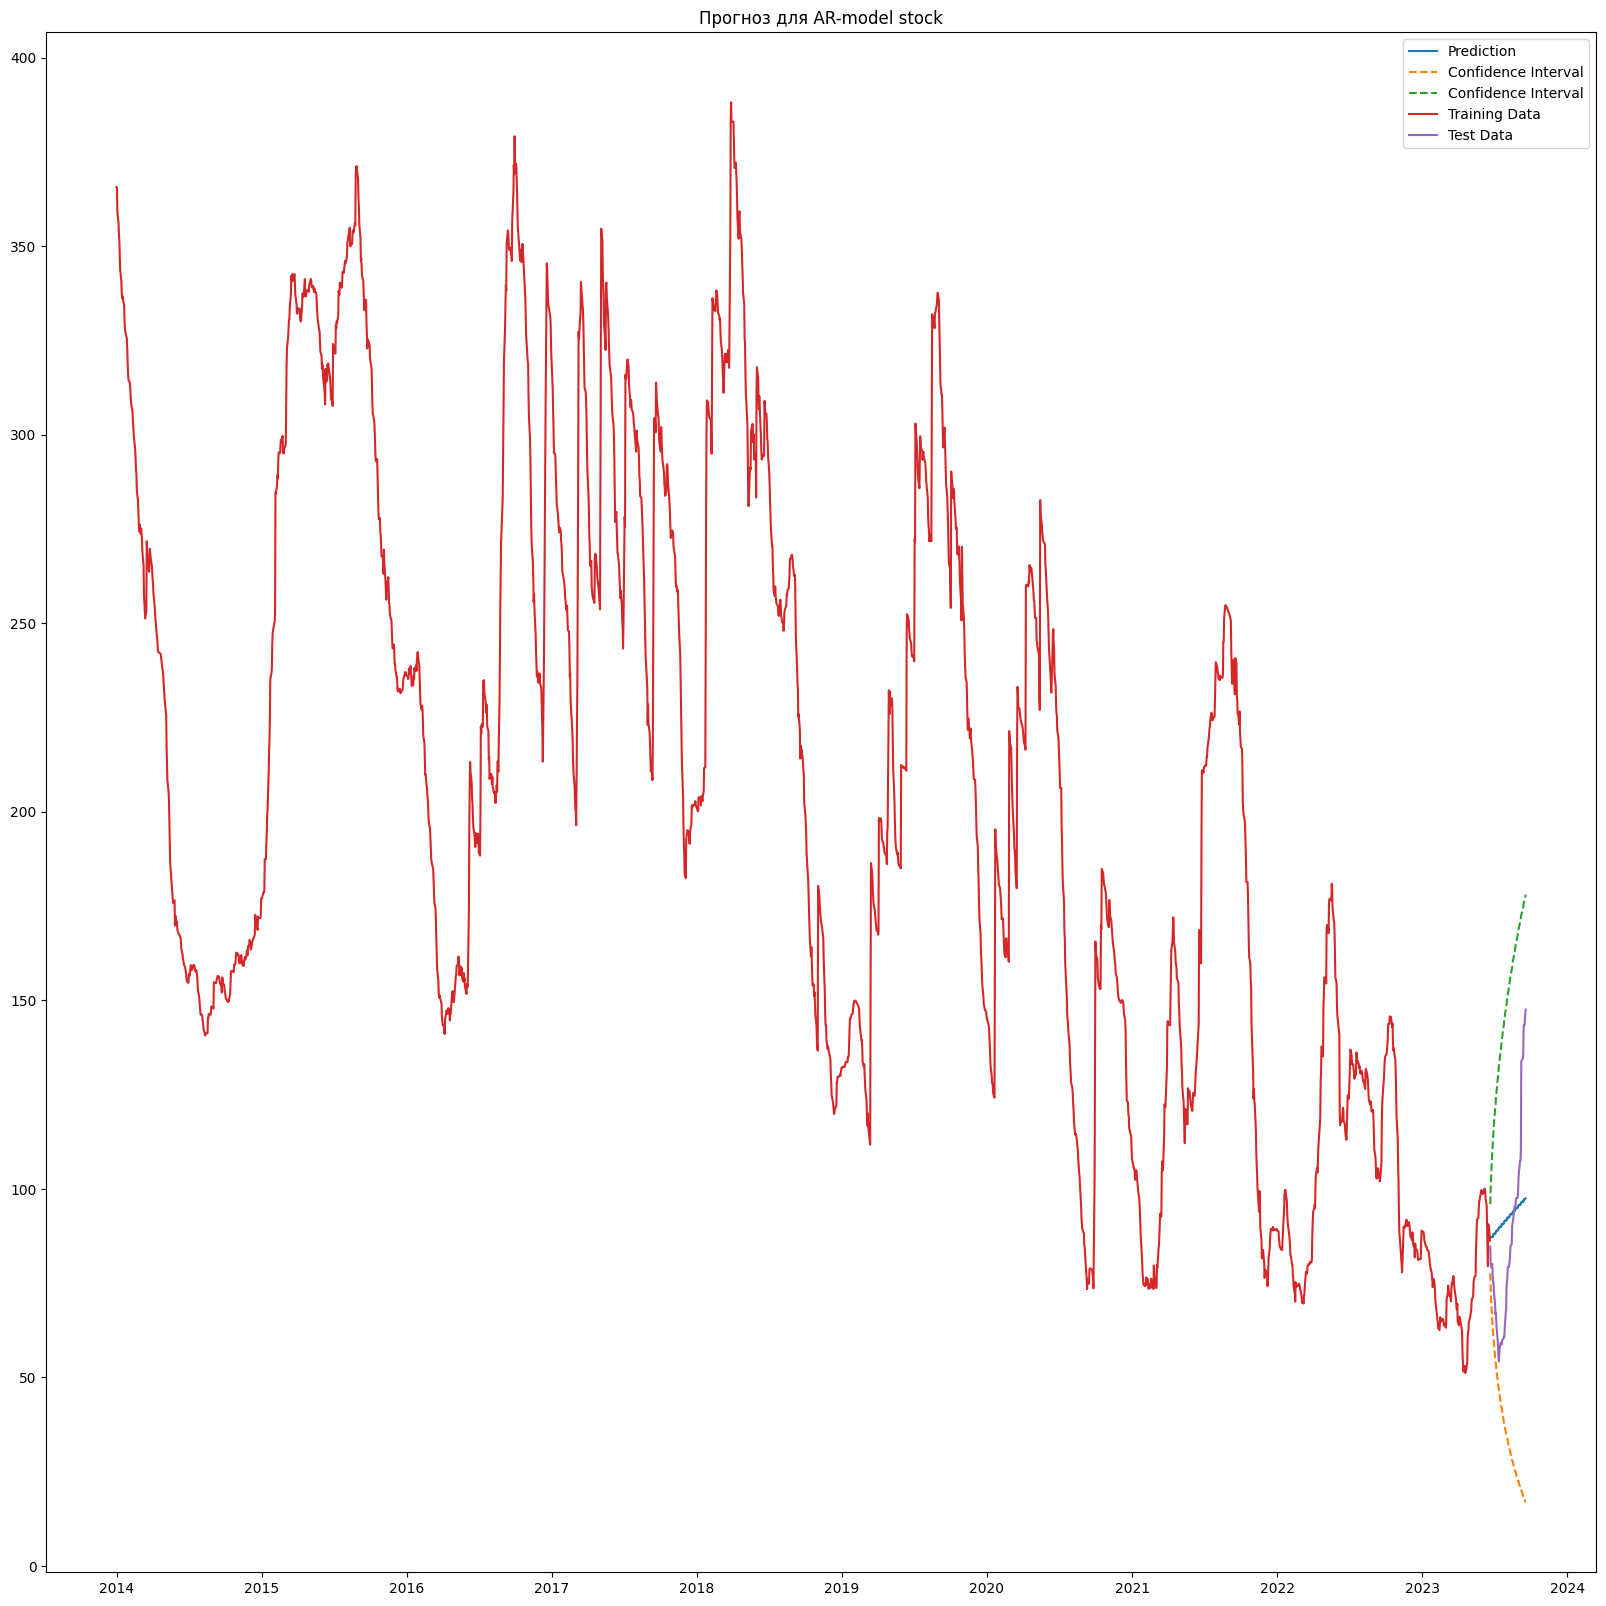

In [1019]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

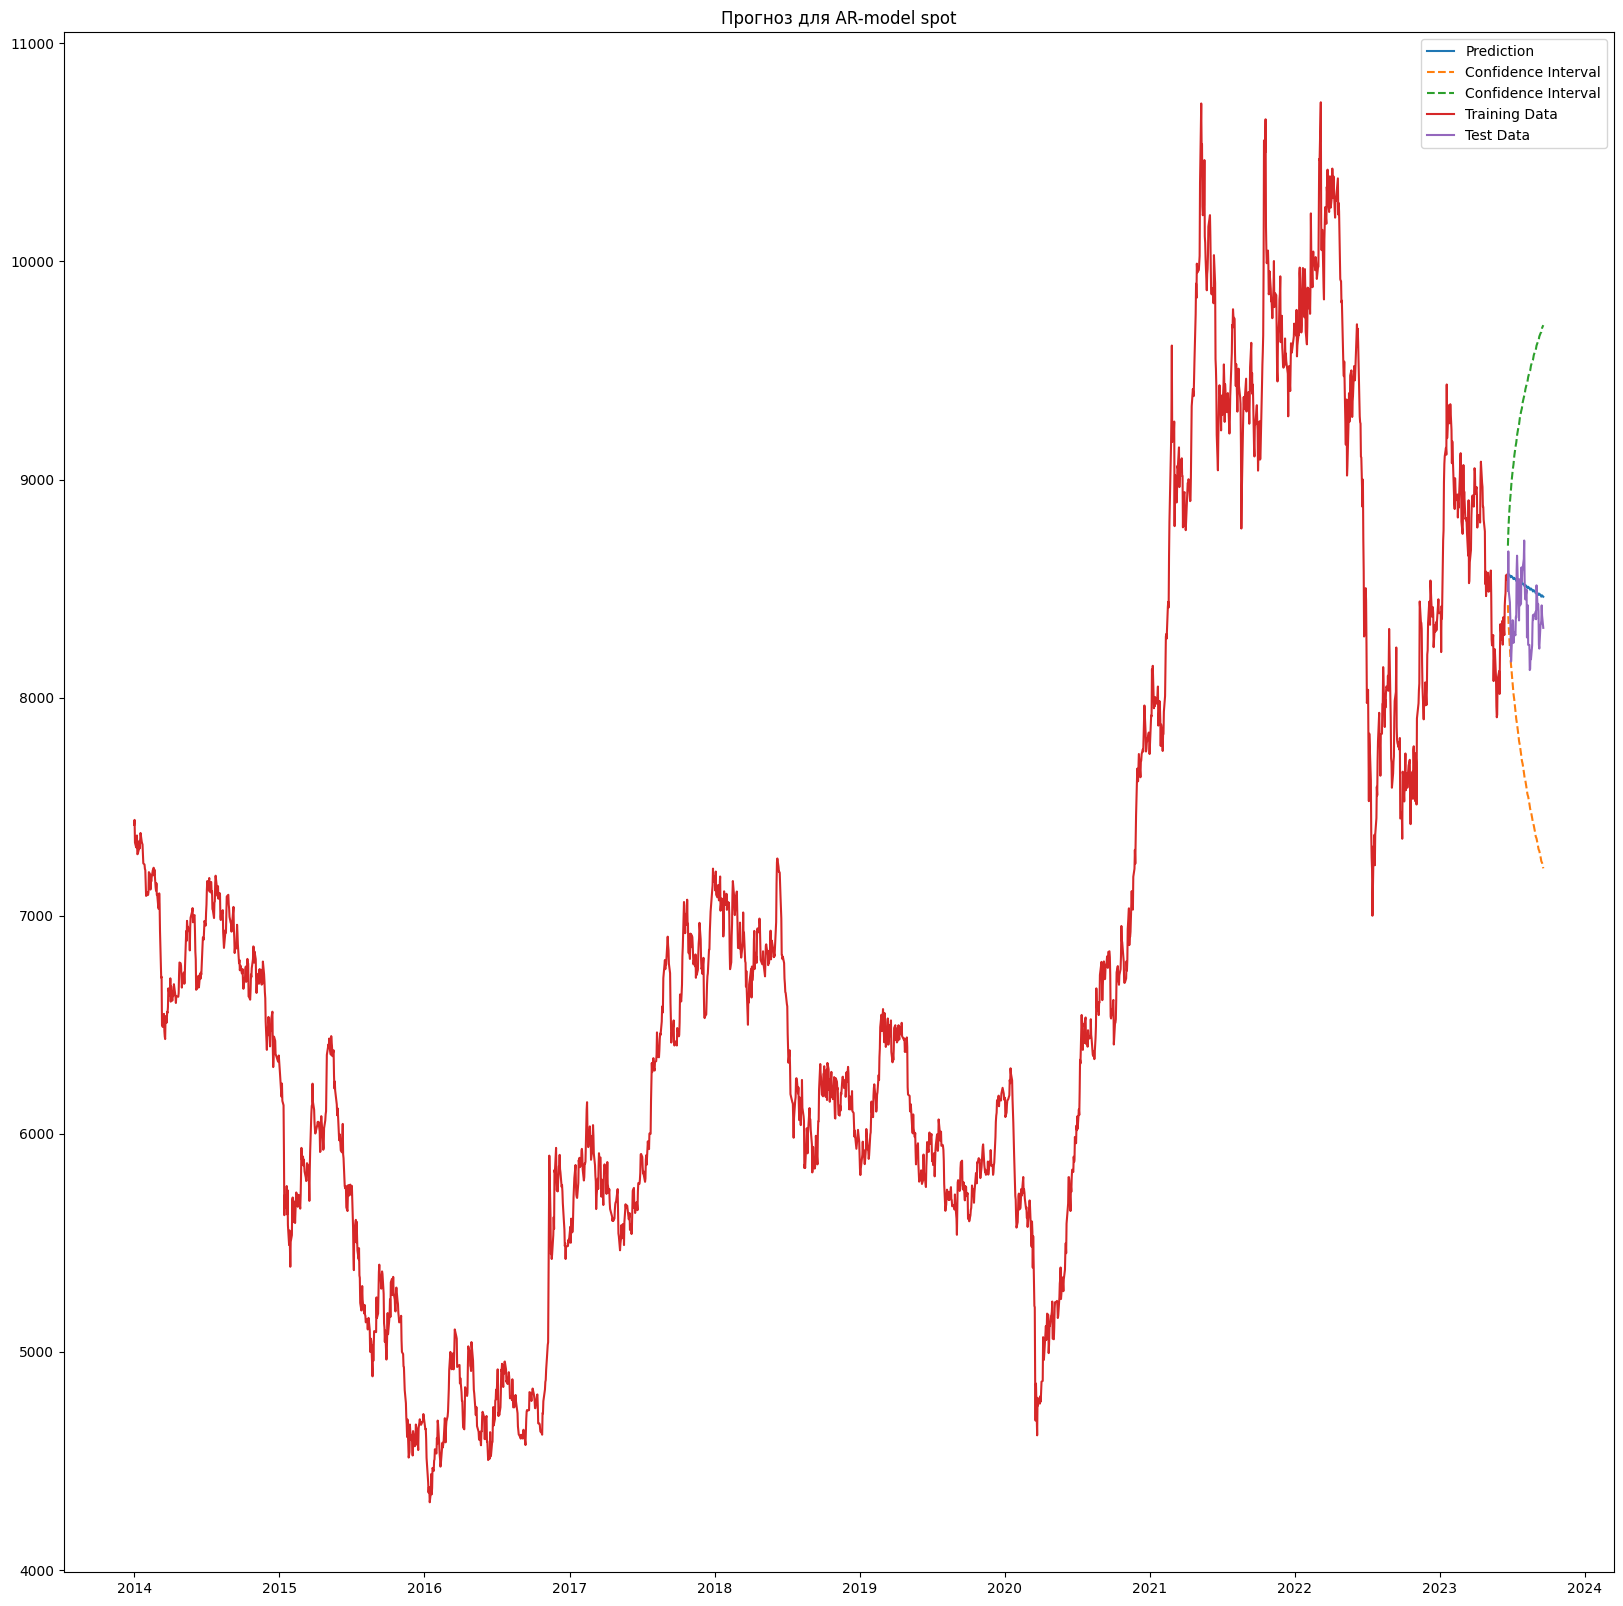

In [1020]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьмаширок
> Что говорит о вероято слабой прогностической способности в бою.

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1 - d=1)

In [1021]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [1022]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 25.623
MAE для ARIMA-stock: 20.155
MAPE для ARIMA-stock: 23.7%


RMSE для ARIMA-spot: 219.208
MAE для ARIMA-spot: 190.943
MAPE для ARIMA-spot: 2.3%




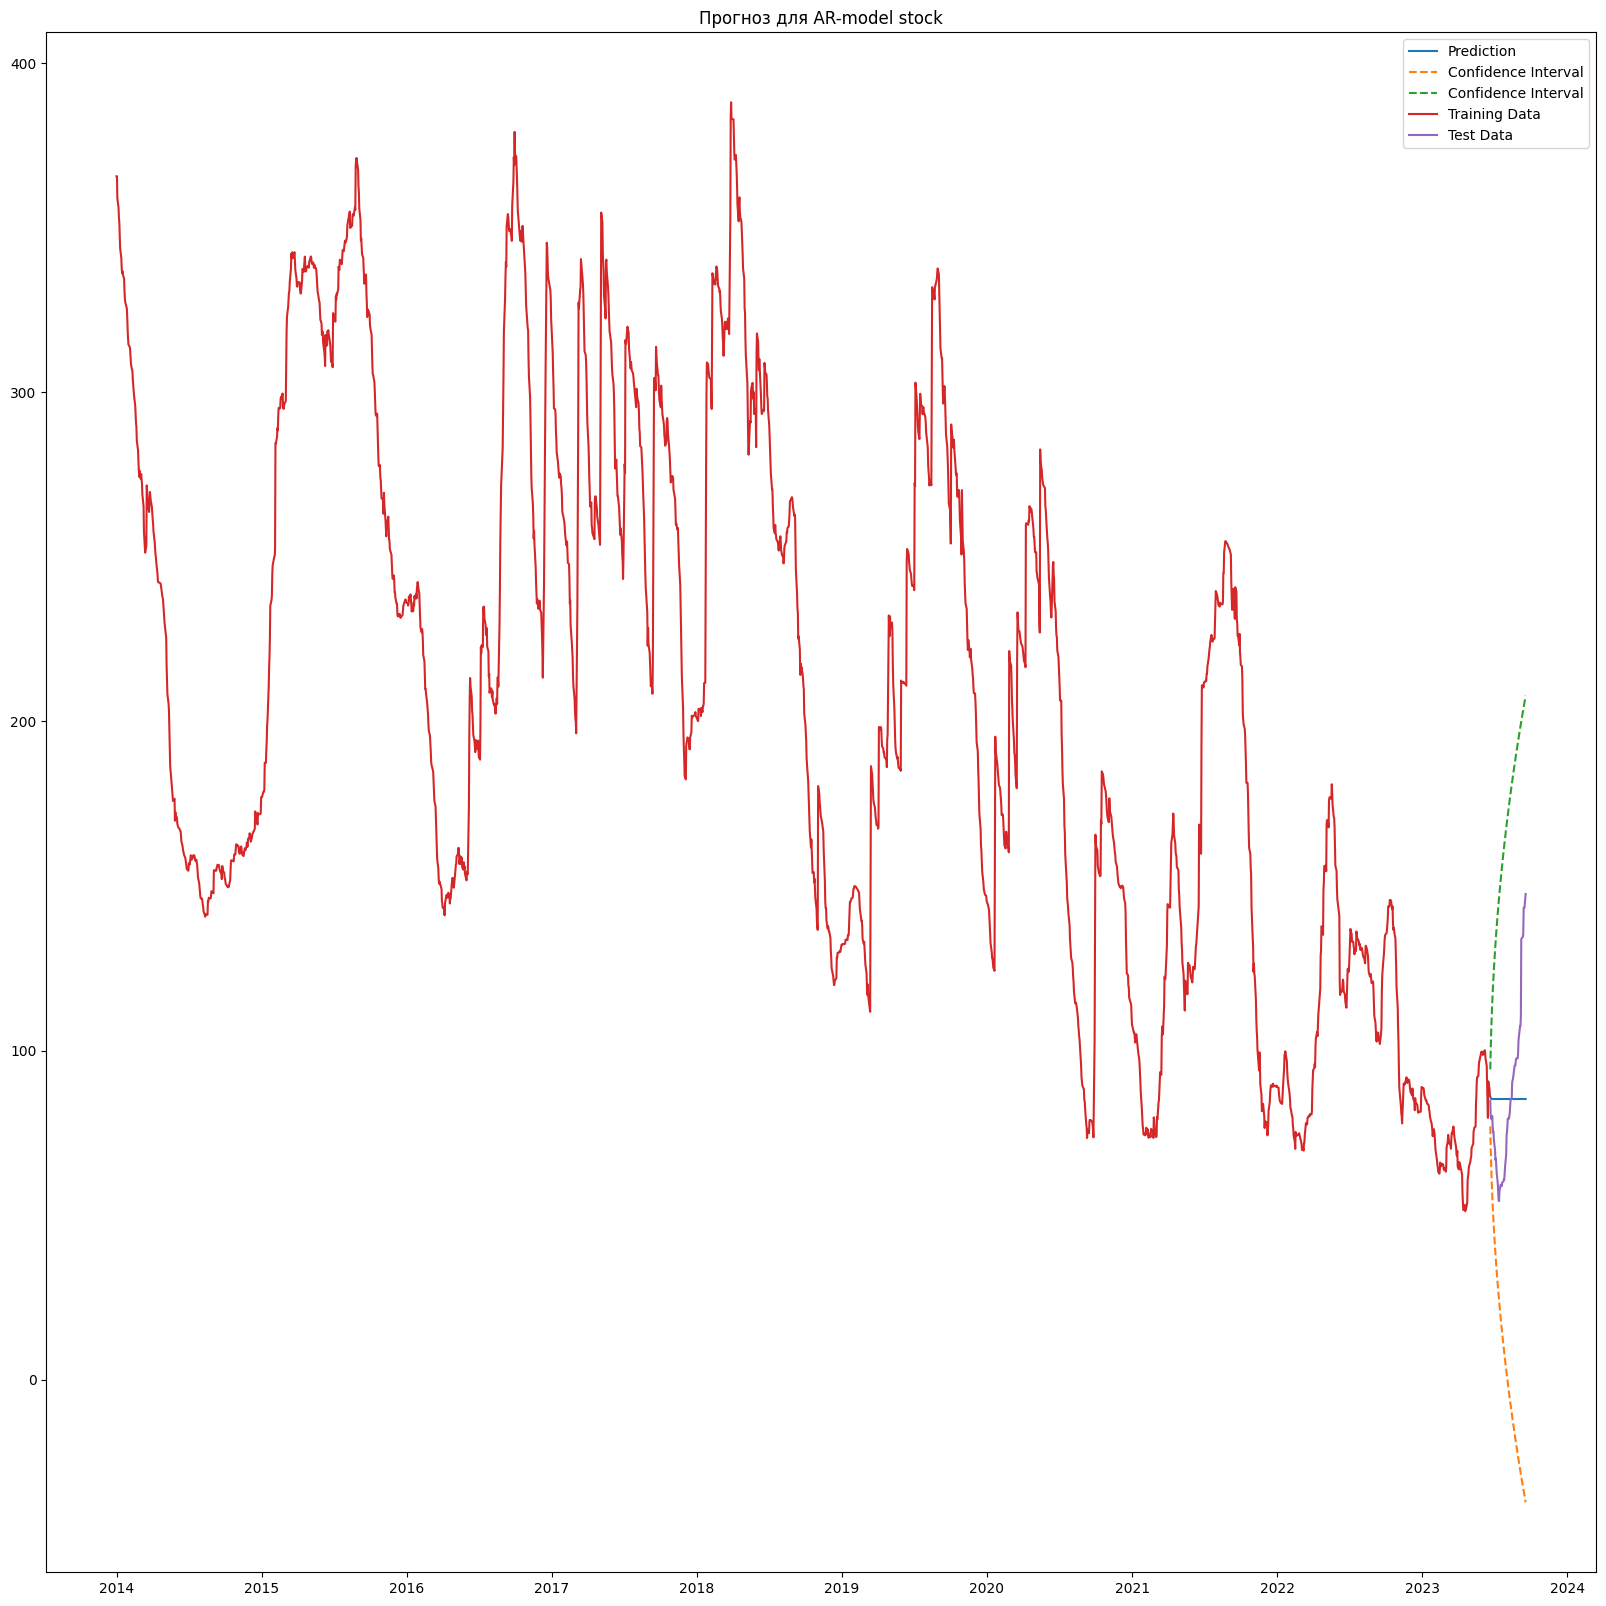

In [1023]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

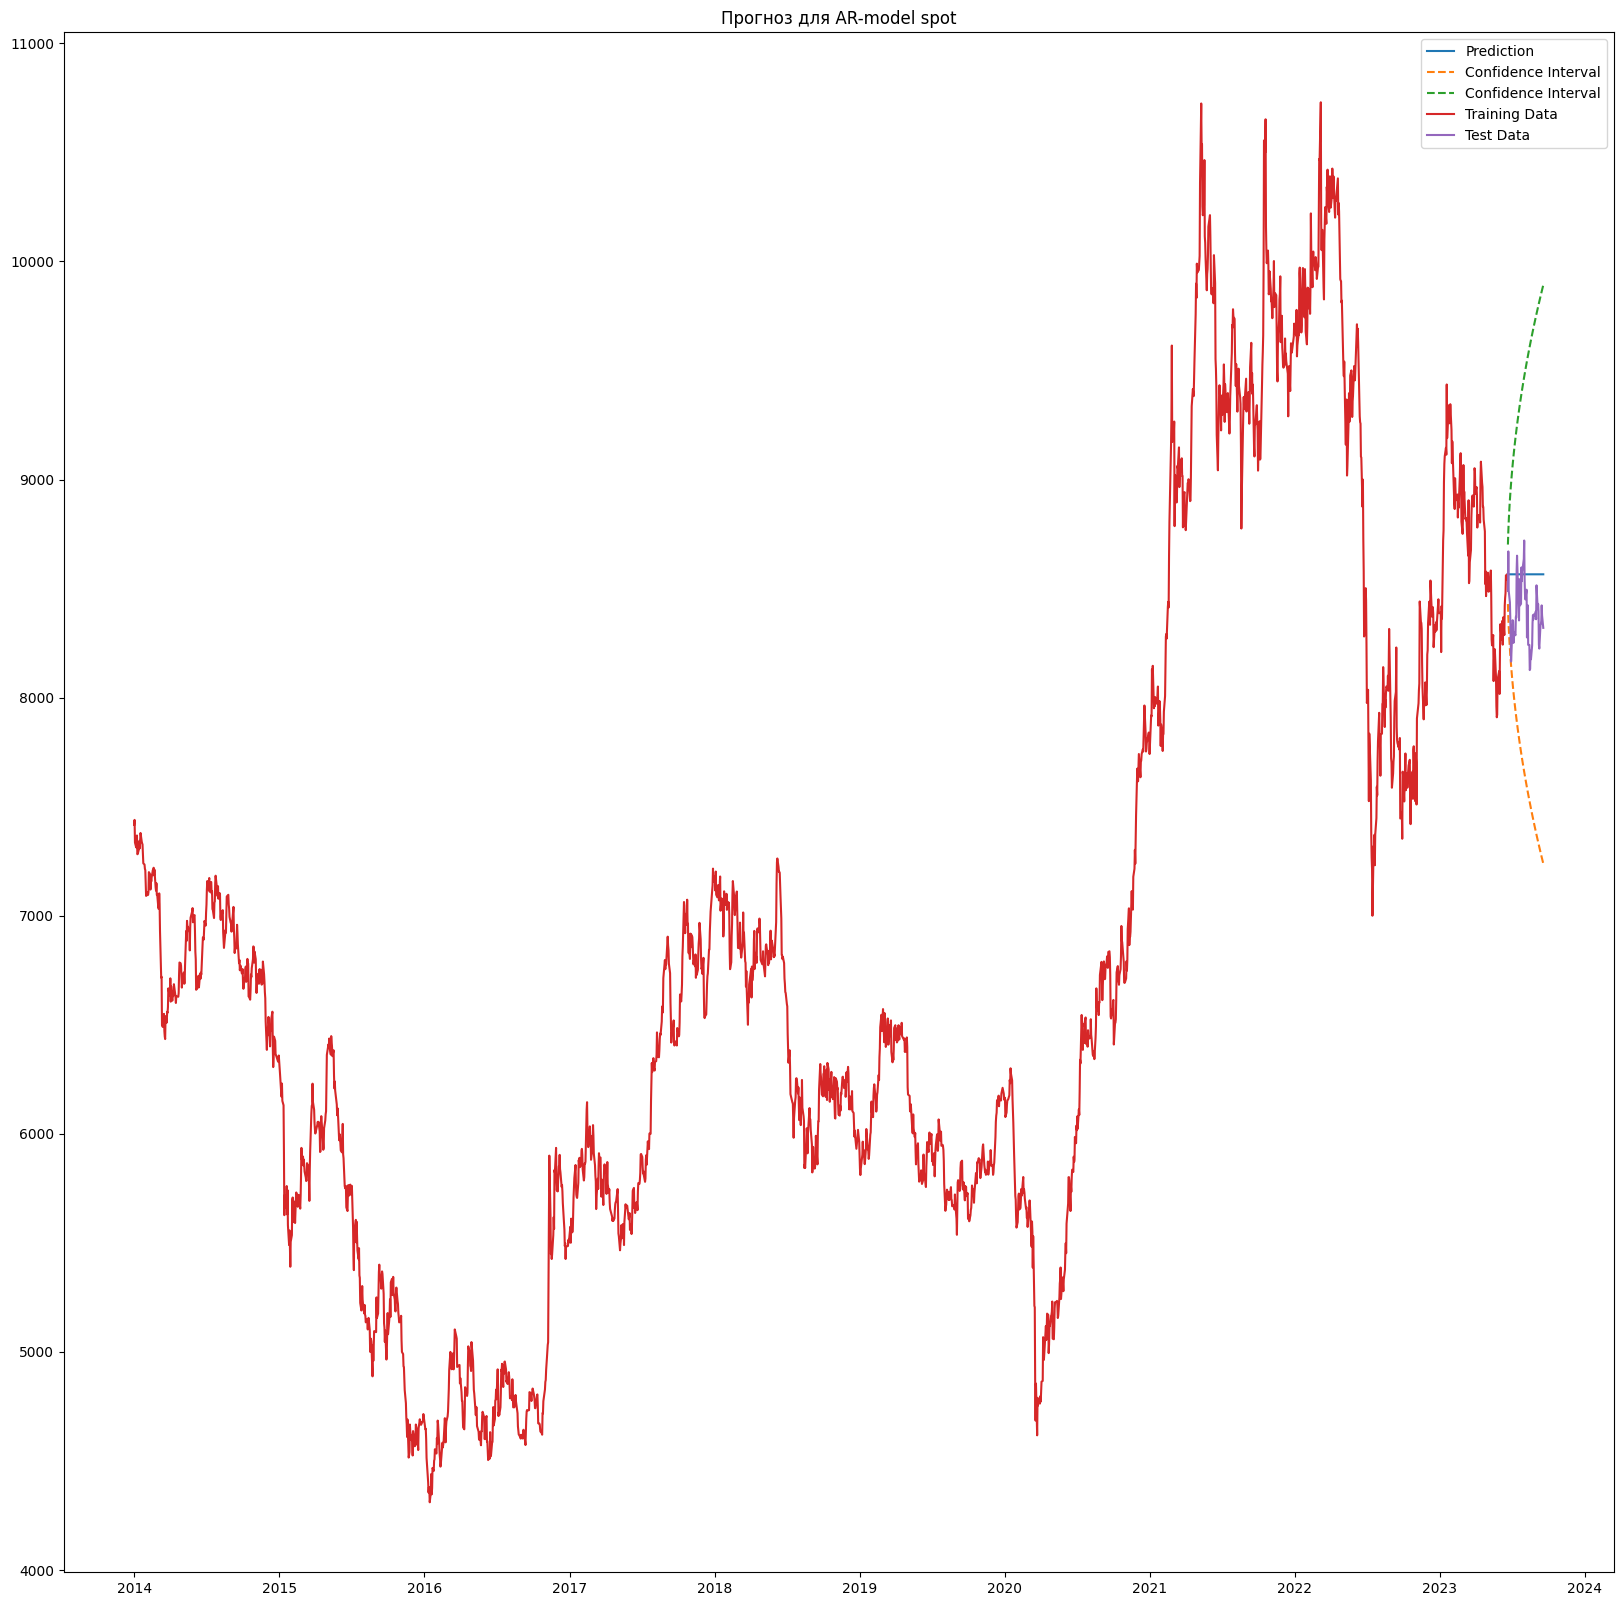

In [1024]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [1025]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=22594.359, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=21275.332, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.70 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=22252.946, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=20969.950, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=8.12 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=3.09 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=21327.101, Time=0.72 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=20939.466, Time=0.84 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=21254.394, Time=0.63 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=11.11 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=5.19 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=20940.031, Time=1.52 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=20939.465, Time=1.82 sec
 ARIMA(2,1,1)(1,1,0)[7]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3458
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 7)   Log Likelihood              -10463.771
Date:                            Tue, 19 Sep 2023   AIC                          20937.542
Time:                                    07:20:26   BIC                          20968.272
Sample:                                01-01-2014   HQIC                         20948.517
                                     - 06-20-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5836      0.028     20.593      0.000       0.528       0.639
ma.L1         -0.3011      0.032     -9.377      0.000      -0.364      -0.238
ar.S.L7       -0.6472      0.007    -94.347      0.000      -0.661      -0.634
ar.S.L14      -0.2972      0.007    -42.044      0.000      -0.311      -0.283
sigma2        25.2062      0.150    167.622      0.000      24.912      25.501
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            142691.90
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             3.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1026]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=41528.487, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=40501.273, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=41527.841, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=40013.843, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.53 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=40014.177, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=40011.198, Time=1.23 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=40498.714, Time=0.99 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.38 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.48 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=40013.052, Time=1.83 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=40013.027, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3458
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -20000.599
Date:                           Tue, 19 Sep 2023   AIC                          40011.198
Time:                                   07:21:00   BIC                          40041.929
Sample:                               01-01-2014   HQIC                         40022.174
                                    - 06-20-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0251      0.011      2.324      0.020       0.004       0.046
ar.L2          0.0367      0.013      2.760      0.006       0.011       0.063
ar.S.L7       -0.6926      0.010    -67.663      0.000      -0.713      -0.673
ar.S.L14      -0.3641      0.010    -36.127      0.000      -0.384      -0.344
sigma2      6344.1823     72.551     87.445      0.000    6201.985    6486.379
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7966.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.36   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1027]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [1028]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX
Best model_stock:  ARIMA(1,1,1)(2,1,0)[7] 

Best model_spot:  ARIMA(2,1,0)(2,1,0)[7] 

### SARIMAX

In [1029]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [1030]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы 
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05781D+00    |proj g|=  5.17753D-02


 This problem is unconstrained.



At iterate    5    f=  3.02599D+00    |proj g|=  1.08546D-03

At iterate   10    f=  3.02596D+00    |proj g|=  6.16356D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   4.961D-07   3.026D+00
  F =   3.0259603174344680     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82607D+00    |proj g|=  3.58570D-03

At iterate    5    f=  5.80521D+00    |proj g|=  8.73682D-02

At iterate   10    f=  5.78386D+00    |proj g|=  8.83990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   1.686D-06   5.784D+00
  F =   5.7838632636777065     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE для SARIMAX-stock: 54.773
MAE для SARIMAX-stock: 39.258
MAPE для 

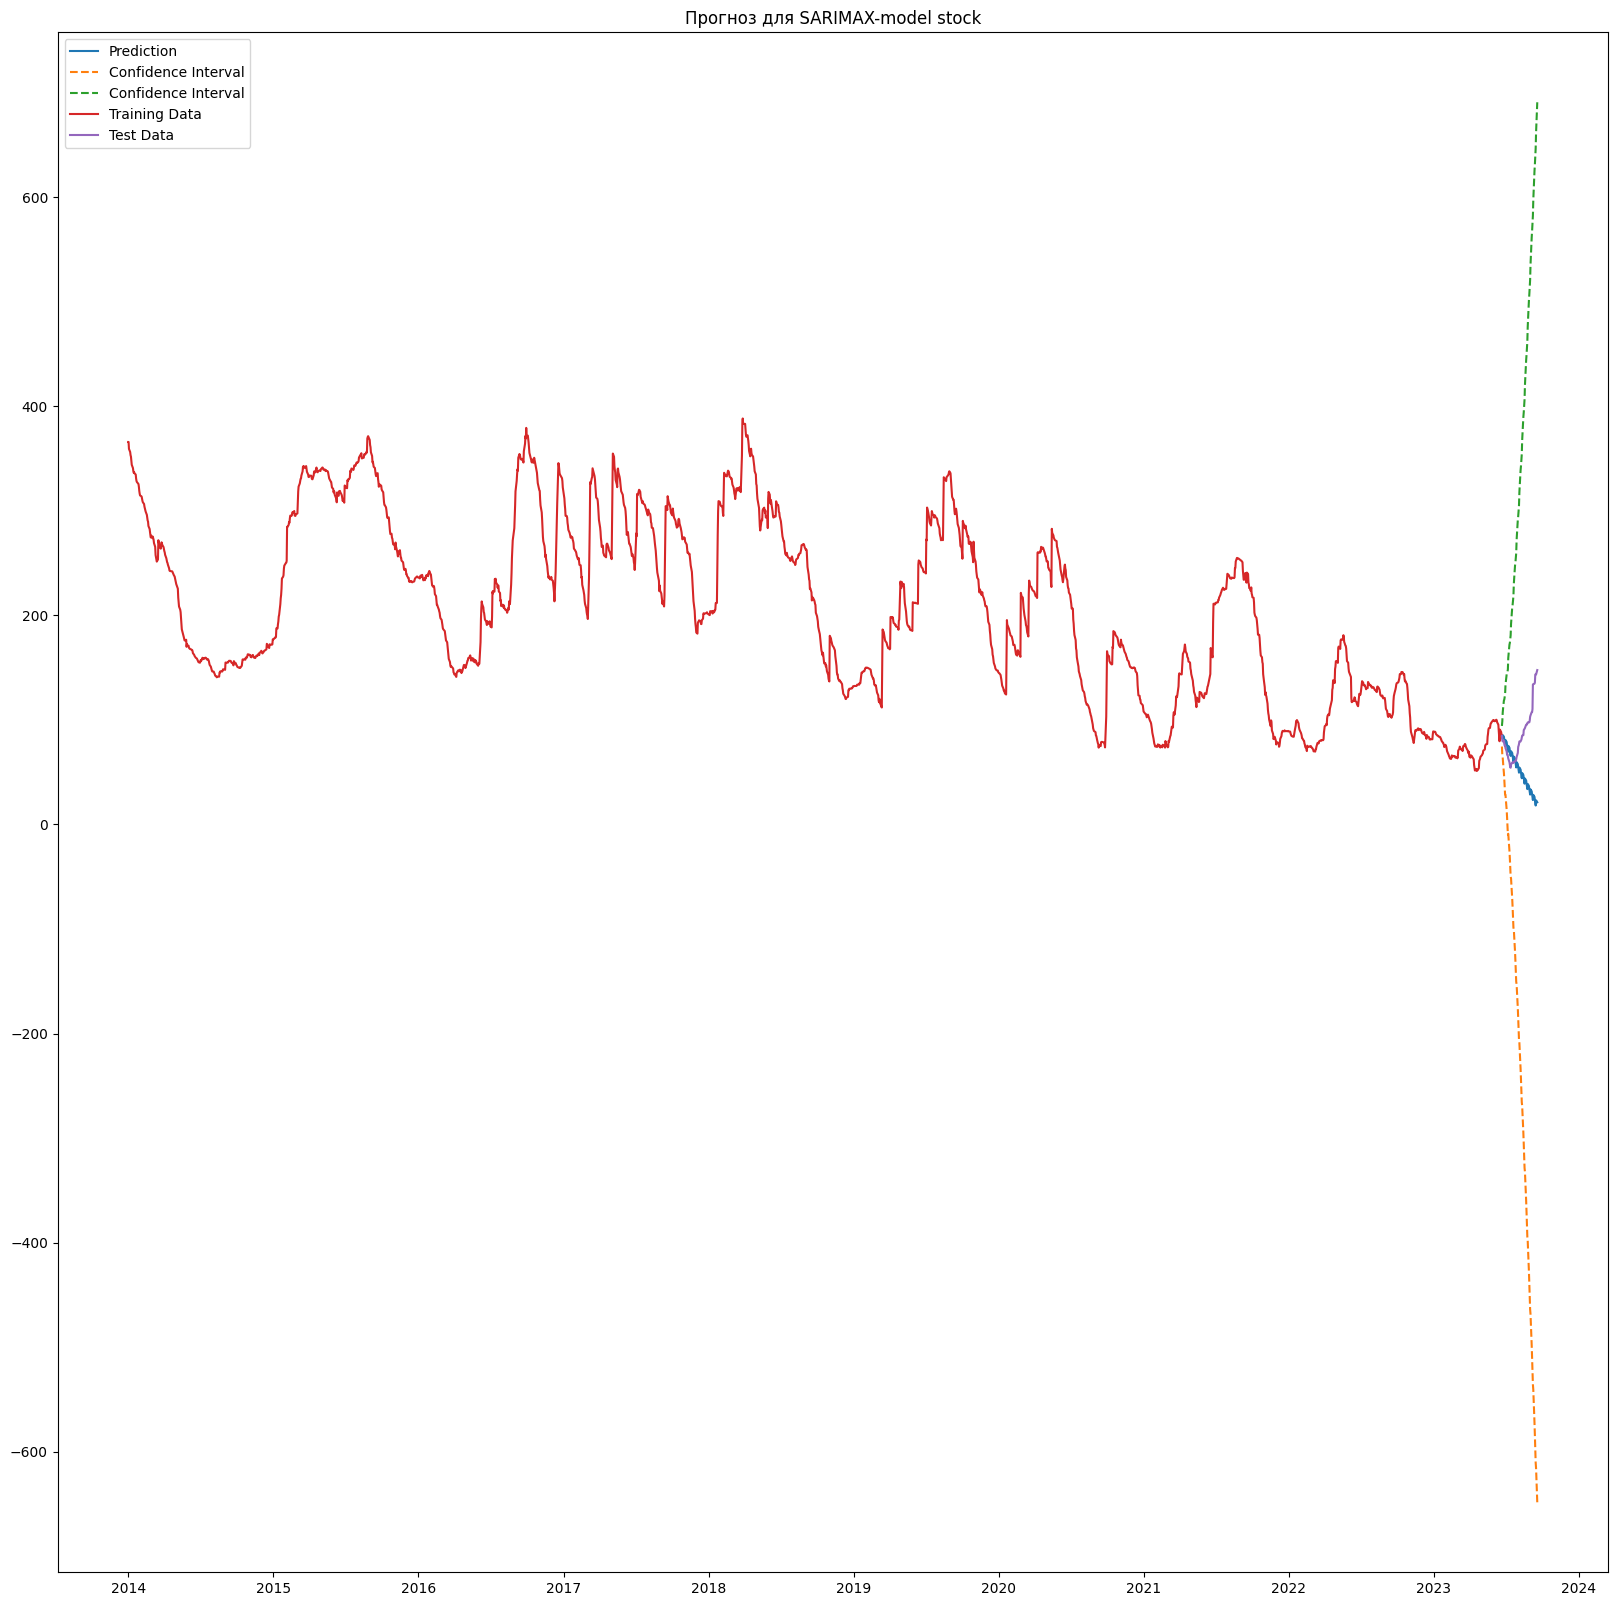

In [1031]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

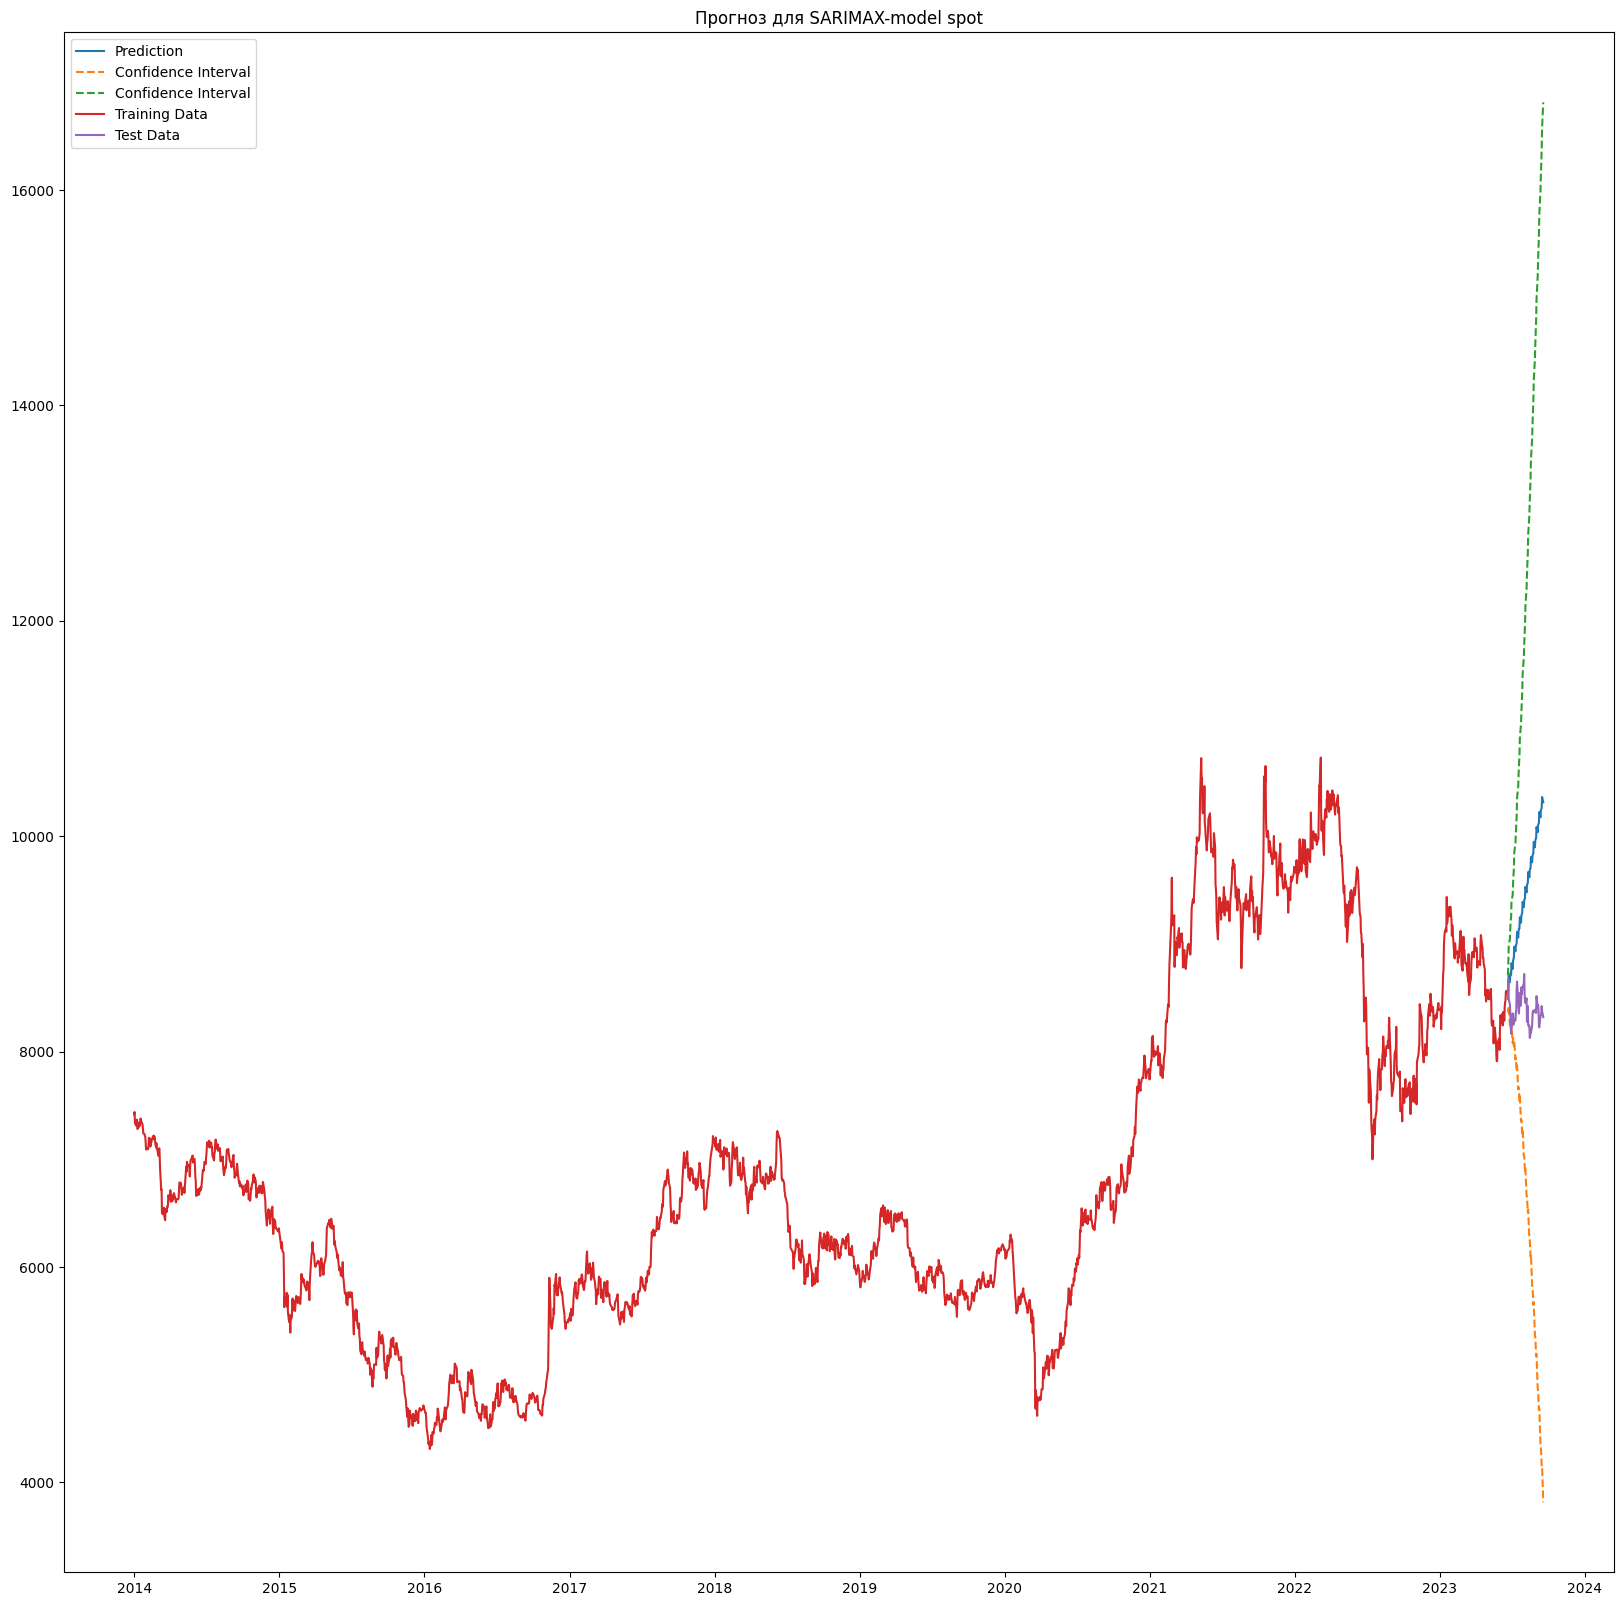

In [1032]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [1033]:
# Инициализируем модель
garch_stock = arch_model(train_stock, lags=1, vol='GARCH', p=1, q=1, rescale=True).fit()
garch_spot = arch_model(train_spot, lags=1, vol='GARCH', p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(start=len(train_stock), horizon=len(test_stock))
pred_garch_spot = garch_spot.forecast(start=len(train_spot), horizon=len(test_spot))

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")


Iteration:      1,   Func. Count:      6,   Neg. LLF: 98890.069926519
Iteration:      2,   Func. Count:     13,   Neg. LLF: 18970.992371834633
Iteration:      3,   Func. Count:     18,   Neg. LLF: 18961.237966768284
Iteration:      4,   Func. Count:     23,   Neg. LLF: 19868.61621690211
Iteration:      5,   Func. Count:     29,   Neg. LLF: 21402.984315075293
Iteration:      6,   Func. Count:     35,   Neg. LLF: 21658.167206855203
Iteration:      7,   Func. Count:     41,   Neg. LLF: 18773.153006189954
Iteration:      8,   Func. Count:     46,   Neg. LLF: 18732.938767505482
Iteration:      9,   Func. Count:     51,   Neg. LLF: 20892.592412055503
Iteration:     10,   Func. Count:     57,   Neg. LLF: 18687.561778104417
Iteration:     11,   Func. Count:     62,   Neg. LLF: 18805.4197083204
Iteration:     12,   Func. Count:     68,   Neg. LLF: 20946.07791937128
Iteration:     13,   Func. Count:     74,   Neg. LLF: 18815.89888821618
Iteration:     14,   Func. Count:     80,   Neg. LLF: 18687

> GARCH не сощелся.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [1034]:
# Посмотри на лучшую модель для запасов
results = pd.read_csv('./data/errors/stock.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-stock
1          ARIMA-stock
Name: model_name, dtype: object

In [1035]:
# И для spota
results = pd.read_csv('./data/errors/spot.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-spot
Name: model_name, dtype: object

In [1036]:
# Посмотрим на картины прогнозов для этих моделей
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-04    95.888283
2023-09-05    95.762091
2023-09-06    96.223125
2023-09-07    96.523022
2023-09-08    96.396496
2023-09-09    96.493197
2023-09-10    96.589554
2023-09-11    96.685569
2023-09-12    96.557968
2023-09-13    97.017597
2023-09-14    97.316091
2023-09-15    97.188163
2023-09-16    97.283466
2023-09-17    97.378427
2023-09-18    97.473048
Freq: D, dtype: float64

2023-09-04    85.27671
2023-09-05    85.27671
2023-09-06    85.27671
2023-09-07    85.27671
2023-09-08    85.27671
2023-09-09    85.27671
2023-09-10    85.27671
2023-09-11    85.27671
2023-09-12    85.27671
2023-09-13    85.27671
2023-09-14    85.27671
2023-09-15    85.27671
2023-09-16    85.27671
2023-09-17    85.27671
2023-09-18    85.27671
Freq: D, dtype: float64

In [1037]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему 
# выбор пал на базовую модель, дело в том, что различие в метриках 
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее () 
best_ts = pred_ar_stock

In [1038]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-09    96.493197
2023-09-10    96.589554
2023-09-11    96.685569
2023-09-12    96.557968
2023-09-13    97.017597
2023-09-14    97.316091
2023-09-15    97.188163
2023-09-16    97.283466
2023-09-17    97.378427
2023-09-18    97.473048
dtype: float64

In [1039]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[['LME Copper Cash-Settlement', 'LME Copper 3-month']], stock_column],
    axis=1).rename(columns={0: 'LME Copper Stock'})

display(working_data.head(), working_data.tail())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2014-01-01,7417.000000,7245.5,365.700000
2014-01-02,7439.500000,7182.0,365.700000
2014-01-03,7335.500000,7189.5,359.075000
2014-01-04,7328.166667,7197.0,358.091667
2014-01-05,7320.833333,7204.5,357.108333


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-14,8423.000000,8575.000000,143.375
2023-09-15,8376.500000,8566.666667,143.375
2023-09-16,8357.666667,8558.333333,144.775
2023-09-17,8338.833333,8550.000000,146.175
2023-09-18,8320.000000,8550.000000,147.575


In [1040]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]


In [1041]:
# Тренировочная эндогенная
endog_train = train.iloc[:,0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:,1:]
exog_test = test.iloc[:,1:]
#exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:,0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [1042]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [1043]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(start=start, end=end, exog=exog_test)

In [1044]:
log_metrics_spot(metrics_calculation(pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 203.236
MAE для ARIMAX-spot: 175.517
MAPE для ARIMAX-spot: 2.1%




> Вывод: Неплохой показатель, но все равно хуже чем у baseline модели

---

## Часть 2.

### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [1045]:
# Сформируем трейн/тест
X_train = train.drop('LME Copper Cash-Settlement', axis=1)
y_train = train['LME Copper Cash-Settlement']

X_test = test.drop('LME Copper Cash-Settlement', axis=1)
y_test = test['LME Copper Cash-Settlement']

---

#### Linear Regression

In [1046]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
log_metrics_stock(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 388.328
MAE для LR-model: 313.121
MAPE для LR-model: 3.6999999999999997%




---

#### Decision Tree regressor

In [1047]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [1048]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)
dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
log_metrics_stock(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 486.491
MAE для DT-model: 433.193
MAPE для DT-model: 5.2%




---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [1049]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(np.array(X_train['LME Copper 3-month']).reshape(-1, 1), y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 400}

In [1050]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

rfr_model.fit(np.array(X_train['LME Copper 3-month']).reshape(-1, 1), y_train)

pred_rfr_model = rfr_model.predict(np.array(X_test['LME Copper 3-month']).reshape(-1, 1))
log_metrics_stock(metrics_calculation(y_test, pred_rfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 464.14
MAE для RFR-model_no_stock: 441.121
MAPE для RFR-model_no_stock: 5.3%




#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [1051]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}

In [1052]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
log_metrics_stock(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 243.752
MAE для RFR-model: 199.047
MAPE для RFR-model: 2.4%




> Вывод: Как можно наблюдать, использование остатков было не плохой идеей, при том лучший результат показала модель со сформированными base-line моделью остатками, но итоговые метрики хуже чем ARIMA или AR-baseline.

----

### Stacking

In [1053]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

# Определяем базовые модели для стекинга
base_models = [('LR-model', linear_regression_model), ('RandomForest', random_forest_model), ('Decision Tree', decsion_tree_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 236.423
MAE для Stacking: 193.31
MAPE для Stacking: 2.3%




---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250% на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)

#### Для этого возьмем уже готовый AR прогноз и склеим с тренировочными данными, затем сгрупируем по месяцам и найдем интересующие нас показатели

---

#### Посмотрим на разброс по среднемесячным показателям

In [1054]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_cu = cu_df.reset_index().groupby(pd.Grouper(key='date', freq='M')).mean()
real_cu = real_cu.tail(3)
real_cu = real_cu.reset_index()
real_cu['date'] = pd.to_datetime(real_cu['date'])
real_cu = real_cu.rename(
    columns={'date': 'Date', 'LME Copper Cash-Settlement': 'LME Copper Spot_real'})
real_cu = real_cu.iloc[:, :2]
real_cu

,Date,LME Copper Spot_real
0,2023-07-31,8445.261905
1,2023-08-31,8351.772727
2,2023-09-30,8363.0


In [1055]:
final_raw = pd.concat([train_spot, pred_ar_spot]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME Copper Spot_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result = pd.DataFrame(final.groupby(pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result = round(result, -1)
result

,Date,LME Copper Spot_pred
0,2023-07-31,8540.0
1,2023-08-31,8500.0
2,2023-09-30,8470.0


In [1056]:
result_table = pd.merge(left=result, right=real_cu)
result_table['Delta'] = result_table['LME Copper Spot_pred'] - \
    result_table['LME Copper Spot_real']
    
result_table['Delta_%'] = (result_table['Delta']/result_table['LME Copper Spot_real'])*100

display(result_table)
print(f'Mean delta: {round(result_table["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table["Delta_%"].mean(),4)}')

,Date,LME Copper Spot_pred,LME Copper Spot_real,Delta,Delta_%
0,2023-07-31,8540.0,8445.261905,94.738095,1.12179
1,2023-08-31,8500.0,8351.772727,148.227273,1.7748
2,2023-09-30,8470.0,8363.0,107.0,1.279445


Mean delta: 116.6551
Mean delta_%: 1.392


---

#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [1057]:
# Расчитаем истинное среднее для квартала
real_cu = cu_df.reset_index()

real_cu = real_cu.rename(columns={'date': 'Date', 'LME Copper Cash-Settlement': 'LME Copper Spot_real'})

real_cu['Date'] = pd.to_datetime(real_cu['Date'])

real_cu = real_cu[
    (real_cu['Date'].dt.year == 2023) &
    (real_cu['Date'].dt.month.isin([7, 8, 9]))
]

real_cu = real_cu.iloc[:, :2]
quarter_real = round(real_cu['LME Copper Spot_real'].mean(),4)
quarter_real 

8389.9182

In [1058]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME Copper Spot_pred'].mean(),-1)
quarter_pred

8510.0

In [1059]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

120.0818

> Вывод:

> Мы получили удовлетворительные результаты при формировании прогнозных цен. Теперь нам стоит определить механизм расчета доверительного интервала для формирования картины экономики двух состояний.

> Нам нужно определить верхнюю и нижнюю границы, это будут наши негативный и позитивный варианты (расчитать для них вероятность).

> Так же мы должны визуализировать полученные результаты для каждого из 3 прогнозируемых месяцев и для квартала.

----

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

In [1060]:
# Создадим унифицированную стабильную модель
# Блок предподготовки данных
data = pd.read_csv(
    './data/copper.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)
data = data.resample('d').interpolate(method='linear')
data = data.iloc[:, 1]

train = data.iloc[:-90]
test = data.iloc[-90:]

In [1061]:
# Подберем парамтр p
model_pmarima = pm.auto_arima(
    train, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_pmarima
p = model_pmarima.get_params()['order'][0]

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=45621.734, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=44439.201, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.60 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=45620.701, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43926.096, Time=1.40 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.18 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=43929.051, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=43924.149, Time=1.83 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=44437.602, Time=1.12 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=6.05 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=3.46 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=43926.027, Time=2.50 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=43926.036, Time=2.87 sec
 ARIMA(1,1,1)(2,1,0)[7]        

In [1062]:
# Произведем прогноз моделью AutoReg
ar_model = AutoReg(train, lags=p, seasonal=True).fit()
pred = ar_model.predict(start=len(train), end=len(train)+len(test)-1)

In [1074]:
# Создадим интервал ошибки на основе MAPE
conf_int = mean_absolute_percentage_error(test, pred).round(3)
conf_int

0.014

In [1064]:
# Построим доверительный интервал
forecast = ar_model.get_prediction(
    start=len(train), end=len(train)+len(test)-1)
conf = forecast.conf_int(alpha=0.05)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [1066]:
# Расчитаем вероятности ошибок на модельных месяцах
resid = (data - pd.concat([train, pred])).reset_index()
resid = resid.rename(columns={'index': 'date', 0: 'resid'})
resid['date'] = pd.to_datetime(resid['date'])
resid['year'] = resid['date'].dt.year
resid['month'] = resid['date'].dt.month
resid = resid[resid['year'] == resid['year'].max()]
months = [resid['month'].max()-2, resid['month'].max()-1, resid['month'].max()]
resid_month = resid[resid['month'].isin(months)]

# Распределение ошибок по месяцам
first_month = resid[resid['month'] == months[0]]
second_month = resid[resid['month'] == months[1]]
third_month = resid[resid['month'] == months[2]]
quart_resid = resid_month

# Вероятность приближения к верхней и нижней границе
p_up_first = round((first_month['resid'] > 0 ).sum()/len(first_month['resid']), 3)
p_down_first = round((first_month['resid'] < 0 ).sum()/len(first_month['resid']), 3)

p_up_second = round((second_month['resid'] > 0 ).sum()/len(second_month['resid']), 3)
p_down_second = round((second_month['resid'] < 0 ).sum()/len(second_month['resid']), 3)

p_up_third = round((third_month['resid'] > 0 ).sum()/len(third_month['resid']), 3)
p_down_third= round((third_month['resid'] < 0 ).sum()/len(third_month['resid']), 3)

# Вероятность приближения к верхней и нижней границе в квартале
p_up_quart = round((quart_resid['resid'] > 0 ).sum()/len(quart_resid['resid']), 3)
p_down_quart = round((quart_resid['resid'] < 0 ).sum()/len(quart_resid['resid']), 3)

# Создадим строку датафрейма
p_max = pd.DataFrame({'p_max':[p_up_first, p_up_second, p_up_third]})
p_min = pd.DataFrame({'p_min':[p_down_first, p_down_second, p_down_third]})
p_quart_max = pd.DataFrame({'p_max':[p_up_quart]})
p_quart_min = pd.DataFrame({'p_min':[p_down_quart]})

In [1067]:
# Сформируем итоговую таблицу прогноза для месяцев
new_data = pd.concat([train, pred]).reset_index()
new_data = new_data.rename(columns={'index': 'date', 0: 'price'})
new_data['date'] = pd.to_datetime(new_data['date'])
month_data = new_data.groupby(pd.Grouper(key='date', freq='M')).mean()
month_data = month_data.tail(3)
month_data['max'] = month_data['price']+(month_data['price']*conf_int)
month_data['min'] = month_data['price']-(month_data['price']*conf_int)
month_data = round(month_data, -1)

# Сформируем прогнозную таблицу для месяцев
month_data.reset_index(inplace=True)
forecast_month = pd.concat([month_data, p_max, p_min], axis=1)
display(forecast_month)

,date,price,max,min,p_max,p_min
0,2023-07-31,8510.0,8630.0,8390.0,0.387,0.613
1,2023-08-31,8460.0,8580.0,8340.0,0.258,0.742
2,2023-09-30,8420.0,8540.0,8300.0,0.389,0.611


In [1068]:
# Проделаем манипуляции для квартальной строки
quart_data = new_data.groupby(pd.Grouper(key='date', freq='Q')).mean().tail(1)
quart_data.reset_index(inplace=True)
quart_data['max'] = quart_data['price']+(quart_data['price']*conf_int)
quart_data['min'] = quart_data['price']-(quart_data['price']*conf_int)
quart_data = round(quart_data, -1)
forecast_quart = pd.concat([quart_data, p_quart_max, p_quart_min], axis=1)
forecast_quart['date'] = forecast_quart['date'].to_string()
forecast_quart['date'] = '3 months ahead'
display(forecast_quart)

,date,price,max,min,p_max,p_min
0,3 months ahead,8470.0,8590.0,8350.0,0.338,0.662


In [1069]:
# Объединим месяцы и квартал в итоговый продукт
result = pd.concat([forecast_month, forecast_quart], axis=0)
display(result)

,date,price,max,min,p_max,p_min
0,2023-07-31 00:00:00,8510.0,8630.0,8390.0,0.387,0.613
1,2023-08-31 00:00:00,8460.0,8580.0,8340.0,0.258,0.742
2,2023-09-30 00:00:00,8420.0,8540.0,8300.0,0.389,0.611
0,3 months ahead,8470.0,8590.0,8350.0,0.338,0.662


> Все отлично, но что с реальным прогнозом, сейчас мы спрогнозируем реальный 4 квартал и используем полученные вероятности приведя их к месяцу, и используем MAE для формирования доверительного интервала. Да сомнительно, но попробовать стоит.

In [1070]:
# Произведем прогноз моделью AutoReg
ar_model_real = AutoReg(data, lags=p, seasonal=True).fit()
pred_real = ar_model_real.predict(start=len(data), end=len(data)+89)

In [1071]:
# Сформируем итоговую таблицу прогноза для месяцев
new_data = pd.concat([train, pred_real]).reset_index()
new_data = new_data.rename(columns={'index': 'date', 0: 'price'})
new_data['date'] = pd.to_datetime(new_data['date'])
month_data = new_data.groupby(pd.Grouper(key='date', freq='M')).mean()
month_data = month_data.tail(3)
month_data['max'] = month_data['price']+(month_data['price']*conf_int)
month_data['min'] = month_data['price']-(month_data['price']*conf_int)
month_data = round(month_data, -1)

# Сформируем прогнозную таблицу для месяцев
month_data.reset_index(inplace=True)
forecast_month = pd.concat([month_data, p_max, p_min], axis=1)
display(forecast_month)

,date,price,max,min,p_max,p_min
0,2023-10-31,8350.0,8460.0,8230.0,0.387,0.613
1,2023-11-30,8300.0,8420.0,8180.0,0.258,0.742
2,2023-12-31,8270.0,8380.0,8150.0,0.389,0.611


In [1072]:
# Проделаем манипуляции для квартальной строки
quart_data = new_data.groupby(pd.Grouper(key='date', freq='Q')).mean().tail(1)
quart_data.reset_index(inplace=True)
quart_data['max'] = quart_data['price']+(quart_data['price']*conf_int)
quart_data['min'] = quart_data['price']-(quart_data['price']*conf_int)
quart_data = round(quart_data, -1)
forecast_quart = pd.concat([quart_data, p_quart_max, p_quart_min], axis=1)
forecast_quart['date'] = forecast_quart['date'].to_string()
forecast_quart['date'] = '3 months ahead'
display(forecast_quart)

,date,price,max,min,p_max,p_min
0,3 months ahead,8310.0,8430.0,8200.0,0.338,0.662


In [1073]:
# Объединим месяцы и квартал в итоговый продукт
result = pd.concat([forecast_month, forecast_quart], axis=0)
day = str(pd.to_datetime(datetime.today(), format='%Y-%m-%d'))
result.to_csv(f'./data/result_{day}.csv', sep=',')
display(result)

,date,price,max,min,p_max,p_min
0,2023-10-31 00:00:00,8350.0,8460.0,8230.0,0.387,0.613
1,2023-11-30 00:00:00,8300.0,8420.0,8180.0,0.258,0.742
2,2023-12-31 00:00:00,8270.0,8380.0,8150.0,0.389,0.611
0,3 months ahead,8310.0,8430.0,8200.0,0.338,0.662


____

### Теперь осталось придумать как все это обернуть в один микросервис, мы должны:
### 1. Модифицировать парсер, что бы он не перезаписывал БД а добавлял дневную строку
### 2. Вывести парсер в отдельный микросервис
### 3. Развести модель которая получает вероятности и модель которая формирует интересующий нас прогноз
### 4. Написать визуализатор